In [1]:
import numpy as np 
import math 
import glob 
import pandas as pd
import scipy.io
import json 
import matplotlib.pyplot as plt
import h5py
import os


/var/folders/v8/zmb9hj_97tjcq8mb570v8wq40000gp/T/ipykernel_6011/2551969211.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def interp1d(array: np.ndarray, new_len: int) -> np.ndarray:
    la = len(array)
    return np.interp(np.linspace(0, la - 1, num=new_len), np.arange(la), array)

def ensure_save_dir(base_dir, subject):
    save_dir = f"{base_dir}/{subject}/eyetracking"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    return save_dir

In [40]:
def plotly_layout_template(task,run):
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
    import numpy as np

    # Horizontal eye trace
    screen_val =  12.5
    ymin1,ymax1,y_tick_num1 = -screen_val,screen_val,11
    y_tick1 = np.linspace(ymin1,ymax1,y_tick_num1)
    xmin1,xmax1,x_tick_num1 = 0,1,5
    x_tick1 = np.linspace(xmin1,xmax1,x_tick_num1)

    # Vertical eye trace
    ymin2,ymax2,y_tick_num2 = -screen_val,screen_val,11
    y_tick2 = np.linspace(ymin2,ymax2,y_tick_num2)
    xmin2,xmax2,x_tick_num2 = 0,1,5
    x_tick2 = np.linspace(xmin2,xmax2,x_tick_num2)

    analysis_info = {'rads': [0,2.5,5,7.5,10,0]}  
    theta = np.linspace(0, 2*np.pi, 100)

    # Constants
    axis_width = 1

    # Create subplots with modified layout
    fig = make_subplots(
        rows=2, cols=3,
        column_widths=[0.5, 0.5, 0],
        horizontal_spacing = 0.1,
        specs=[[{}, {"rowspan": 2},{'type': 'polar'}],
            [{}, None, None]]
    )

    # Plot horizontal eye position
    for rad in analysis_info['rads']:
        fig.add_trace(
            go.Scatter(x=x_tick1, y=x_tick1*0+rad, mode='lines', line=dict(color='black', width=axis_width*0.5)),
            row=1, col=1
        )
        fig.add_trace(
            go.Scatter(x=x_tick1, y=x_tick1*0-rad, mode='lines', line=dict(color='black', width=axis_width*0.5)),
            row=1, col=1
        )

    # Plot vertical eye position
    for rad in analysis_info['rads']:
        fig.add_trace(
            go.Scatter(x=x_tick2, y=x_tick2*0+rad, mode='lines', line=dict(color='black', width=axis_width*0.5)),
            row=2, col=1
        )
        fig.add_trace(
            go.Scatter(x=x_tick2, y=x_tick2*0-rad, mode='lines', line=dict(color='black', width=axis_width*0.5)),
            row=2, col=1
        )

    fig.add_vrect(x0=0, x1=1, row="all", col=1,
                fillcolor="grey", opacity=0.15, line_width=0)

    # Plot screen view
    for rad in analysis_info['rads']:
        fig.add_trace(
            go.Scatter(x=rad*np.cos(theta), y=rad*np.sin(theta), mode='lines', line=dict(color='black', width=axis_width*0.5)),
            row=1, col=2
        )

    fig.add_vrect(x0=-12.5, x1=12.5, row="all", col=2,
                fillcolor="grey", opacity=0.15, line_width=0)

    # Update layout
    y_data = [-12.5,-10.0,-7.5,-5.0,-2.5,0.0,2.5,5.0,7.5,10.0,12.5]
    fig.update_xaxes(title_text="Time (%)", row=1, col=1)
    fig.update_xaxes(title_text="Time (%)", row=2, col=1)
    fig.update_yaxes(title_text="Hor. coord. (dva)",tickvals=y_data, range = [-12.5,12.5], row=1, col=1, title_standoff=0.15)
    fig.update_yaxes(title_text="Ver. coord. (dva)",tickvals=y_data, range = [-12.5,12.5],row=2, col=1, title_standoff=0.15),


    fig.update_xaxes(title_text="Horizontal coordinates (dva)", tickvals=y_data,range = [-12.5,12.5], row=1, col=2)
    fig.update_yaxes(title_text="Vertical coordinates (dva)", tickvals=y_data,range = [-12.5,12.5], row=1, col=2, title_standoff=0.15)



    fig.update_layout(
        showlegend=False,
        title=f"Eye Positions {task}, run {run + 1}",
        height=700,
        width=1420,  
        template="simple_white", 
        margin=dict(
            l=100,
            r=10,
            b=100,
            t=100
        )
    )


    return fig 


In [37]:
subject = 'sub-04'
task = 'SacLoc'
ses = 'ses-02'

In [38]:
# data paths
if subject == 'sub-01': 
    data_mat = sorted(glob.glob(r'/Users/sinakling/projects/PredictEye/locEMexp/data/{}/ses-01/add/*.mat'.format(subject)))
    matfile = scipy.io.loadmat(data_mat[0])

    data_events = sorted(glob.glob(r'/Users/sinakling/projects/PredictEye/locEMexp/data/{}/ses-01/func/*.tsv'.format(subject)))
    data_events = data_events[:2]

else: 
    data_mat = sorted(glob.glob(r'/Users/sinakling/projects/PredictEye/locEMexp/data/{}/ses-02/add/*.mat'.format(subject)))
    matfile = scipy.io.loadmat(data_mat[0])

    data_events = sorted(glob.glob(r'/Users/sinakling/projects/PredictEye/locEMexp/data/{}/ses-02/func/*.tsv'.format(subject)))
    data_events = data_events[:2]


In [39]:
# extract event files 
num_run = len(data_events)
dfs_runs = []

# Read each TSV file 
for i, run in enumerate(data_events):
    df_run = pd.read_csv(run, sep="\t")
    dfs_runs.append(df_run)

In [40]:
# load data
with open('/Users/sinakling/projects/pRF_analysis/RetinoMaps/eyetracking/dev/SacLoc_behavior_settings.json') as f:
		json_s = f.read()
		analysis_info = json.loads(json_s)


main_dir = analysis_info['main_dir_mac']
file_dir_save = ensure_save_dir(f'{main_dir}/derivatives/pp_data', subject)

h5_filename = f'{file_dir_save}/stats/{subject}_task-{task}_eyedata_sac_stats.h5'
h5_file = h5py.File(h5_filename,'r')
time_start_trial = np.array(h5_file['time_start_trial'])
time_end_trial = np.array(h5_file['time_end_trial'])
time_start_seq = np.array(h5_file['time_start_seq'])
time_end_seq = np.array(h5_file['time_end_seq'])
time_start_eye = np.array(h5_file['time_start_eye'])
time_end_eye = np.array(h5_file['time_end_eye'])



In [41]:
eye_data_run_01_nan_blink_interpol = pd.read_csv(f"{file_dir_save}/timeseries/{subject}_task-{task}_run_01_eyedata.tsv.gz", compression='gzip', delimiter='\t')
eye_data_run_01_nan_blink_interpol = eye_data_run_01_nan_blink_interpol[['timestamp', 'x', 'y', 'pupil_size']].to_numpy()
eye_data_run_02_nan_blink_interpol = pd.read_csv(f"{file_dir_save}/timeseries/{subject}_task-{task}_run_02_eyedata.tsv.gz", compression='gzip', delimiter='\t')
eye_data_run_02_nan_blink_interpol = eye_data_run_02_nan_blink_interpol[['timestamp', 'x', 'y', 'pupil_size']].to_numpy()

eye_data_all_runs = [eye_data_run_01_nan_blink_interpol,eye_data_run_02_nan_blink_interpol]

In [42]:
saccade_output = np.array(h5_file['saccades_output'])

columns = [
    'run', 'sequence', 'trial', 'saccade_num', 'sac_x_onset', 'sac_x_offset', 'sac_y_onset', 'sac_y_offset',
    'sac_t_onset', 'sac_t_offset', 'sac_p_onset', 'sac_p_offset', 'sac_dur', 'sac_vpeak', 'sac_dist', 'sac_amp',
    'sac_dist_ang', 'sac_amp_ang', 'fix_cor', 'sac_cor', 'saccade_task', 'miss_time', 'sac_out_accuracy', 'sac_in_accuracy', 'no_saccade',
    'microsaccade', 'blink_saccade'
]

# Convert vals_all to a DataFrame
df = pd.DataFrame(saccade_output, columns=columns)

# Filter for correct saccades outwards 
correct_saccades_out = df[df['sac_out_accuracy'] == 1]
# Filter for correct saccades inwards 
correct_saccades_in = df[df['sac_in_accuracy'] == 1]

# Show the filtered DataFrame
#print(correct_saccades_out)


In [9]:
def add_missing_sac_rows(correct_saccades, direction):
    # Define the expected pattern
    if direction == 'out':
        pattern = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0]

    elif direction == 'in': 
        pattern = [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 29.0, 31.0]


    # Filter by sequence 
    correct_saccades_seq_1 = correct_saccades[correct_saccades['sequence'] == 1]
    correct_saccades_seq_3 = correct_saccades[correct_saccades['sequence'] == 3]
    correct_saccades_seq_5 = correct_saccades[correct_saccades['sequence'] == 5]
    correct_saccades_seq_7 = correct_saccades[correct_saccades['sequence'] == 7]
    correct_saccade_by_seq = [correct_saccades_seq_1,correct_saccades_seq_3,correct_saccades_seq_5,correct_saccades_seq_7]

    new_datafr = []

    for i, datafr in enumerate(correct_saccade_by_seq):

        # Get trials for this one sequence
        existing_trials = list(datafr['trial'])
        print(existing_trials)

        missing_trials = []

        # Check for missing trials 
        for trial in pattern:
            if trial not in existing_trials:
                missing_trials.append(trial)
                print(f"Found missing trial {trial}")

        # Add missing rows to the filtered DataFrame
        for trial in missing_trials:
            new_row = {col: 0 for col in correct_saccades.columns}
            new_row['trial'] = trial
            new_row['no_saccade'] = 1
            new_row['run'] = 0
            new_row['sequence'] = i + 1
            datafr = datafr._append(new_row, ignore_index=True)

        # Sort by 'trial' column to maintain order 
        datafr = datafr.sort_values(by='trial')
        new_datafr.append(datafr)
        print(len(datafr))
        

    correct_saccades_new = pd.concat(new_datafr)
    #display(correct_saccades_new)

    return correct_saccades_new

In [43]:
# outwards saccades

correct_saccades_out_run_1 = correct_saccades_out[correct_saccades_out['run'] == 0]
correct_saccades_out_run_1_new = add_missing_sac_rows(correct_saccades_out_run_1, 'out')

correct_saccades_out_run_2 = correct_saccades_out[correct_saccades_out['run'] == 1]
correct_saccades_out_run_2_new = add_missing_sac_rows(correct_saccades_out_run_2, 'out')

# Filter the DataFrame to only include rows where the 'trial' column has even numbers
out_filtered_df_run_1 = correct_saccades_out_run_1_new[correct_saccades_out_run_1_new['trial'] % 2 == 0]  #remove any detected saccades from the wrong trials
out_filtered_df_run_2 = correct_saccades_out_run_2_new[correct_saccades_out_run_2_new['trial'] % 2 == 0]

# combine 2 new dataframes to see if it worked
outwards_saccades = [out_filtered_df_run_1,out_filtered_df_run_2]
correct_saccades_out_new = pd.concat(outwards_saccades)


[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0]
16
[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0]
Found missing trial 16.0
16
[0.0, 2.0, 4.0, 6.0, 7.0, 10.0, 12.0, 16.0, 18.0, 22.0, 24.0, 26.0, 29.0]
Found missing trial 8.0
Found missing trial 14.0
Found missing trial 20.0
Found missing trial 28.0
Found missing trial 30.0
18
[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 16.0, 18.0, 19.0, 22.0, 24.0, 26.0, 28.0, 30.0]
Found missing trial 14.0
Found missing trial 20.0
17
[0.0, 2.0, 3.0, 6.0, 8.0, 10.0, 15.0, 18.0, 20.0, 22.0, 26.0, 30.0]
Found missing trial 4.0
Found missing trial 12.0
Found missing trial 14.0
Found missing trial 16.0
Found missing trial 24.0
Found missing trial 28.0
18
[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 17.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0]
Found missing trial 14.0
Found missing trial 16.0
Found missing trial 18.0
17
[0.0, 2.0, 4.0, 6.0, 7.0, 9.0, 13.0, 16.0, 18.0, 20.0, 22.0, 26.0, 27.0, 

In [44]:
# inwards saccades
correct_saccades_in_run_1 = correct_saccades_in[correct_saccades_in['run'] == 0]
correct_saccades_in_run_1_new = add_missing_sac_rows(correct_saccades_in_run_1, 'in')

correct_saccades_in_run_2 = correct_saccades_in[correct_saccades_in['run'] == 1]
correct_saccades_in_run_2_new = add_missing_sac_rows(correct_saccades_in_run_2, 'in')

# Filter the DataFrame to only include rows where the 'trial' column has even numbers
in_filtered_df_run_1 = correct_saccades_in_run_1_new[correct_saccades_in_run_1_new['trial'] % 2 != 0]  #remove any detected saccades from the wrong trials
in_filtered_df_run_2 = correct_saccades_in_run_2_new[correct_saccades_in_run_2_new['trial'] % 2 != 0]

# combine 2 new dataframes to see if it worked
inwards_saccades = [in_filtered_df_run_1,in_filtered_df_run_2]
correct_saccades_in_new = pd.concat(inwards_saccades)

[1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 26.0, 29.0, 31.0]
Found missing trial 27.0
17
[1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 31.0]
Found missing trial 29.0
16
[1.0, 3.0, 5.0, 7.0, 8.0, 11.0, 13.0, 15.0, 17.0, 18.0, 23.0, 25.0, 29.0, 30.0]
Found missing trial 9.0
Found missing trial 19.0
Found missing trial 21.0
Found missing trial 27.0
Found missing trial 31.0
19
[1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 29.0, 31.0]
Found missing trial 27.0
16
[1.0, 3.0, 5.0, 9.0, 11.0, 13.0, 15.0, 16.0, 19.0, 21.0, 23.0, 25.0, 27.0, 29.0, 31.0]
Found missing trial 7.0
Found missing trial 17.0
17
[1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 14.0, 16.0, 19.0, 21.0, 22.0, 25.0, 27.0, 29.0, 31.0]
Found missing trial 15.0
Found missing trial 17.0
Found missing trial 23.0
19
[1.0, 2.0, 8.0, 12.0, 17.0, 19.0, 21.0, 23.0, 27.0, 29.0, 31.0]
Found missing trial 3.0
Found missing trial 5.0
Found missing trial 7.0


In [45]:

# Convert timestamps
initial_timestamp_run_1 = eye_data_run_01_nan_blink_interpol[0, 0]
initial_timestamp_run_2 = eye_data_run_02_nan_blink_interpol[0, 0]

# Initialize arrays to store onset and offset times in seconds for each run
onset_all_trials_run_1 = np.zeros_like(time_start_trial[:, :, 0])
offset_all_trials_run_1 = np.zeros_like(time_end_trial[:, :, 0])
onset_all_trials_run_2 = np.zeros_like(time_start_trial[:, :, 1])
offset_all_trials_run_2 = np.zeros_like(time_end_trial[:, :, 1])

# Loop through each trial and apply the conversion for run 1
for i in range(time_start_trial.shape[0]):
    for j in range(time_start_trial.shape[1]):
        onset_all_trials_run_1[i, j] = (time_start_trial[i, j, 0] - initial_timestamp_run_1) / 100
        offset_all_trials_run_1[i, j] = (time_end_trial[i, j, 0] - initial_timestamp_run_1) / 100

# Loop through each trial and apply the conversion for run 2
for i in range(time_start_trial.shape[0]):
    for j in range(time_start_trial.shape[1]):
        onset_all_trials_run_2[i, j] = (time_start_trial[i, j, 1] - initial_timestamp_run_2) / 100
        offset_all_trials_run_2[i, j] = (time_end_trial[i, j, 1] - initial_timestamp_run_2) / 100

# Flatten the arrays and filter out non-positive values for run 1
onset_all_trials_flat_run_1 = np.ravel(onset_all_trials_run_1, order='F')
onset_all_trials_flat_run_1 = onset_all_trials_flat_run_1[onset_all_trials_flat_run_1 > 0]

offset_all_trials_flat_run_1 = np.ravel(offset_all_trials_run_1, order='F')
offset_all_trials_flat_run_1 = offset_all_trials_flat_run_1[offset_all_trials_flat_run_1 > 0]

# Flatten the arrays and filter out non-positive values for run 2
onset_all_trials_flat_run_2 = np.ravel(onset_all_trials_run_2, order='F')
onset_all_trials_flat_run_2 = onset_all_trials_flat_run_2[onset_all_trials_flat_run_2 > 0]

offset_all_trials_flat_run_2 = np.ravel(offset_all_trials_run_2, order='F')
offset_all_trials_flat_run_2 = offset_all_trials_flat_run_2[offset_all_trials_flat_run_2 > 0]

print(len(onset_all_trials_flat_run_1), len(offset_all_trials_flat_run_1))
print(len(onset_all_trials_flat_run_2), len(offset_all_trials_flat_run_2))


208 208
207 208


In [46]:
print(offset_all_trials_flat_run_1)
print(offset_all_trials_flat_run_2)

[  12.33   24.33   36.35   48.35   60.37   72.45   84.45   96.45  108.45
  120.45  132.45  144.45  156.47  168.47  180.47  192.49  204.89  216.89
  228.91  240.91  252.91  264.93  276.93  288.93  300.93  312.93  324.93
  336.93  348.95  360.95  372.97  384.97  396.97  408.97  420.97  432.97
  444.97  456.97  468.99  480.99  493.01  505.01  517.01  529.01  541.01
  553.01  565.01  577.01  589.19  601.21  613.21  625.21  637.21  649.21
  661.21  673.21  685.23  697.23  709.25  721.25  733.25  745.25  757.25
  769.25  781.33  793.35  805.35  817.37  829.37  841.37  853.37  865.37
  877.37  889.37  901.39  913.39  925.39  937.41  949.41  961.41  973.41
  985.41  997.41 1009.41 1021.41 1033.43 1045.43 1057.45 1069.45 1081.45
 1093.45 1105.45 1117.45 1129.45 1141.45 1153.45 1165.57 1177.57 1189.57
 1201.57 1213.57 1225.57 1237.57 1249.59 1261.59 1273.59 1285.61 1297.61
 1309.61 1321.61 1333.61 1345.61 1357.79 1369.81 1381.81 1393.81 1405.81
 1417.81 1429.81 1441.81 1453.81 1465.83 1477.83 14

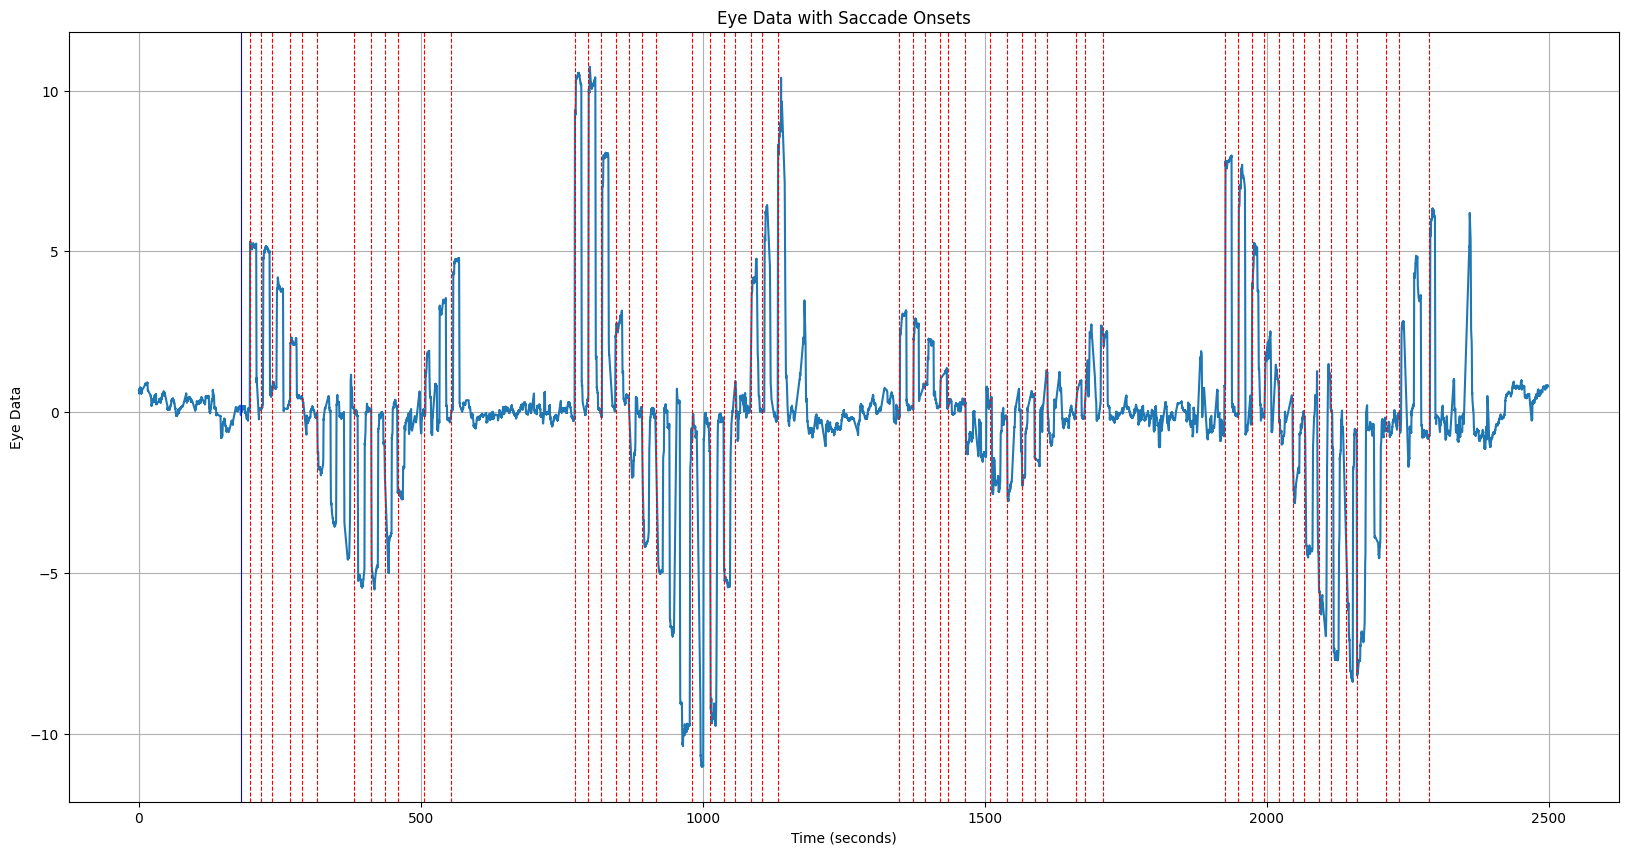

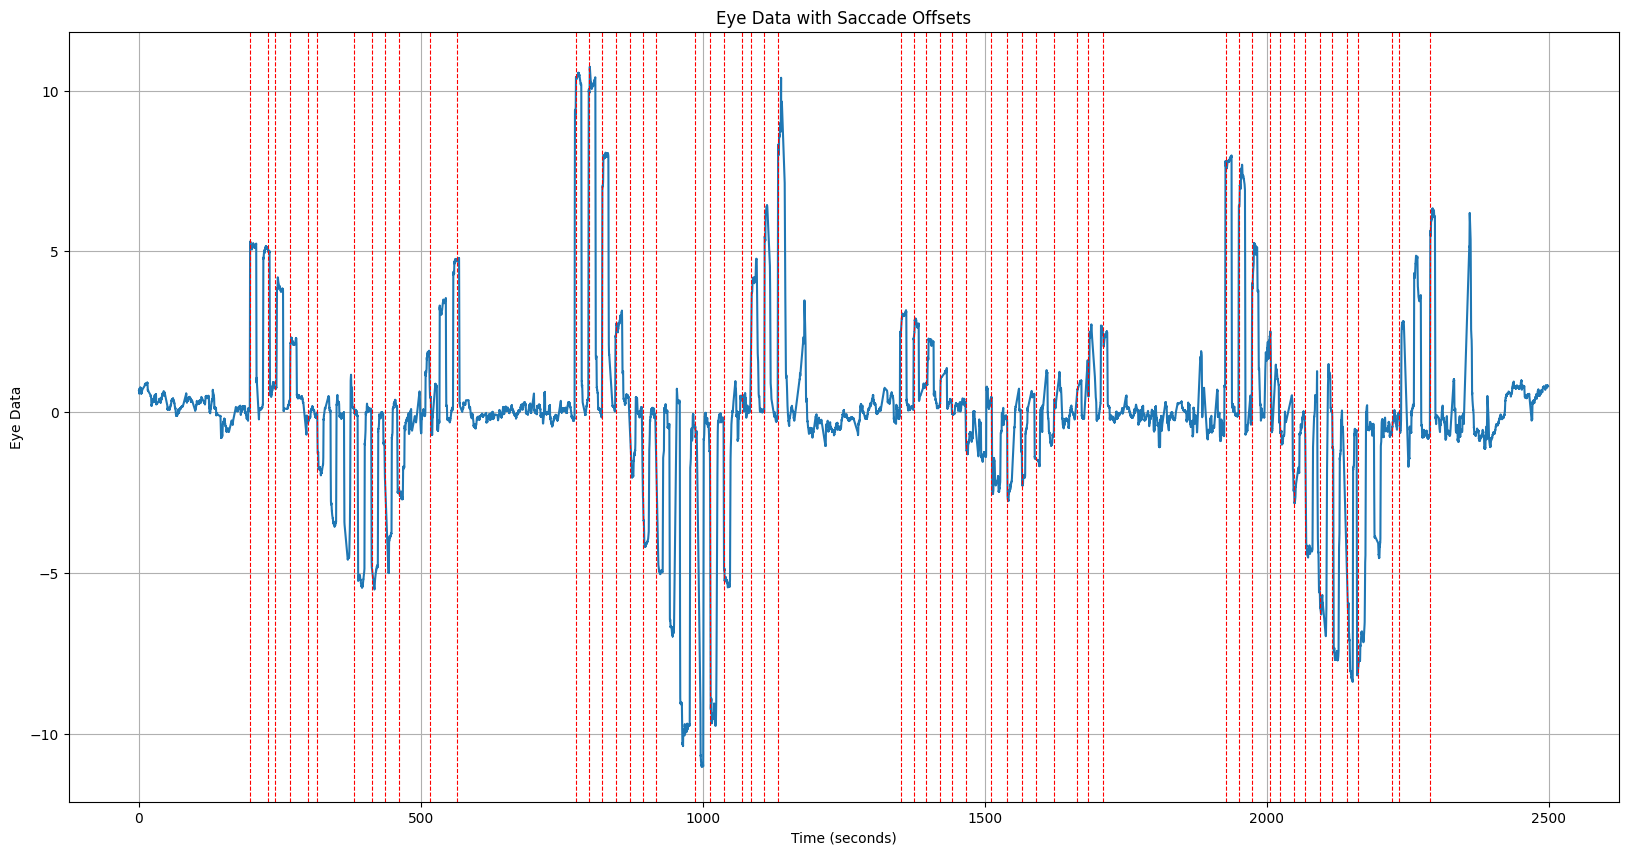

In [47]:
# Plot found correct saccade onsets on top of eye data fro run one for sanity check
import matplotlib.pyplot as plt

# Convert time to seconds, relative to the start of the recording
time_seconds = (eye_data_run_01_nan_blink_interpol[:, 0] - eye_data_run_01_nan_blink_interpol[0, 0]) / 100
eye_data = eye_data_run_01_nan_blink_interpol[:, 1]

correct_sac_out_run_1 = correct_saccades_out[correct_saccades_out['run'] == 0]
correct_sac_in_run_1 = correct_saccades_in[correct_saccades_in['run'] == 0]

correct_sac_out_run_2 = correct_saccades_out[correct_saccades_out['run'] == 1]
correct_sac_in_run_2 = correct_saccades_in[correct_saccades_in['run'] == 1]

# Convert saccade onset times, relative to the start of the recording
correct_sac_out_seconds_on = (correct_sac_out_run_2['sac_t_onset'] - eye_data_run_02_nan_blink_interpol[0, 0]) / 100
correct_sac_out_seconds_off = (correct_sac_out_run_2['sac_t_offset'] - eye_data_run_02_nan_blink_interpol[0, 0]) / 100

correct_sac_in_seconds_on = (correct_sac_in_run_2['sac_t_onset'] - eye_data_run_02_nan_blink_interpol[0, 0]) / 100
correct_sac_in_seconds_off = (correct_sac_in_run_2['sac_t_offset'] - eye_data_run_02_nan_blink_interpol[0, 0]) / 100

plt_1 = plt.figure(figsize=(20, 10)) 

# Plot eye data
plt.plot(time_seconds, eye_data, label='Eye Data')


# Plot saccade onsets
for onset in correct_sac_out_seconds_on:
    plt.axvline(x=onset, color='r', linestyle='--', linewidth=0.8, label='Saccade Onset')

plt.axvline(x=onset_all_trials_flat_run_1[15], color='b', linewidth=0.8, label='Trial Onset')

# Add labels and legend
plt.xlabel('Time (seconds)')
plt.ylabel('Eye Data')
plt.title('Eye Data with Saccade Onsets')
plt.grid(True)

# Show the plot
plt.show()

plt_2 = plt.figure(figsize=(20, 10)) 

# Plot eye data
plt.plot(time_seconds, eye_data, label='Eye Data')


# Plot saccade onsets
for offset in correct_sac_out_seconds_off:
    plt.axvline(x=offset, color='r', linestyle='--', linewidth=0.8, label='Saccade Offset')

# Add labels and legend
plt.xlabel('Time (seconds)')
plt.ylabel('Eye Data')
plt.title('Eye Data with Saccade Offsets')
plt.grid(True)

# Show the plot
plt.show()


In [48]:
# Generate Expected Position 
# extract fixation point position 

# in screen coordinates
# in trial length 

saccade_coord_x = matfile['config']['const'][0,0]['pursuit_matX'][0][0][0] # (4,32) = amp, dir
saccade_coord_y = matfile['config']['const'][0,0]['pursuit_matY'][0][0][0]


amplitude = list(df_run['eyemov_amplitude'])
seq_trial = list(df_run['sequence_trial'])

sac_expected_x = []
sac_expected_y = []

for amp, trial in zip(amplitude, seq_trial):
    if amp == 5: 
        x_coord = 960.0
    else: 
        x_coord = saccade_coord_x[amp-1, trial-1]
    sac_expected_x.append(x_coord)


expected_y = []

for amp, trial in zip(amplitude, seq_trial):
    if amp == 5: 
        y_coord = 540.0
    else: 
        y_coord = saccade_coord_y[amp-1, trial-1]
    sac_expected_y.append(y_coord)

# convert to dva 
sac_expected_x = (np.array(sac_expected_x) - (analysis_info['center'][0]))/analysis_info['ppd']
sac_expected_y =  -1.0*((np.array(sac_expected_y) - (analysis_info['center'][1]))/analysis_info['ppd'])

In [49]:
trials_out = [17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,
              65,67,69,71,73,75,77,79,81,83,85,87,89,91,93,95,
              113,115,117,119,121,123,125,127,129,131,133,135,137,139,141,143,
              161,163,165,167,169,171,173,175,177,179,181,183,185,187,189,191]

trials_in = [16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,
             64,66,68,70,72,74,76,78,80,82,84,86,88,90,92,94,
             112,114,116,118,120,122,124,126,128,130,132,134,136,138,140,142,
             160, 162,164,166,168,170,172,174,176,178,180,182,184,186,188,190]


case 1
case 1
case 1
case 1
case 1
case 1
case 1
case 1
case 1
case 1
case 1
case 1
case 1
case 3
orig onset 508
new set offset 517
case 1
case 1
case 1
case 1
case 1
case 1
case 1
case 1
case 1
case 1
case 2
case 1
case 1
case 1
case 1
case 1
case 3
orig onset 1108
new set offset 1117
case 1
case 1
case 1
case 1
case 1
case 4
case 1
case 1
case 2
case 1
case 3
orig onset 1565
new set offset 1573
case 4
case 1
case 1
case 3
orig onset 1657
new set offset 1669
case 2
case 4
case 1
case 1
case 1
case 1
case 1
case 1
case 1
case 2
case 1
case 1
case 2
case 1
case 1
case 3
orig onset 2237
new set offset 2246
case 1
case 1


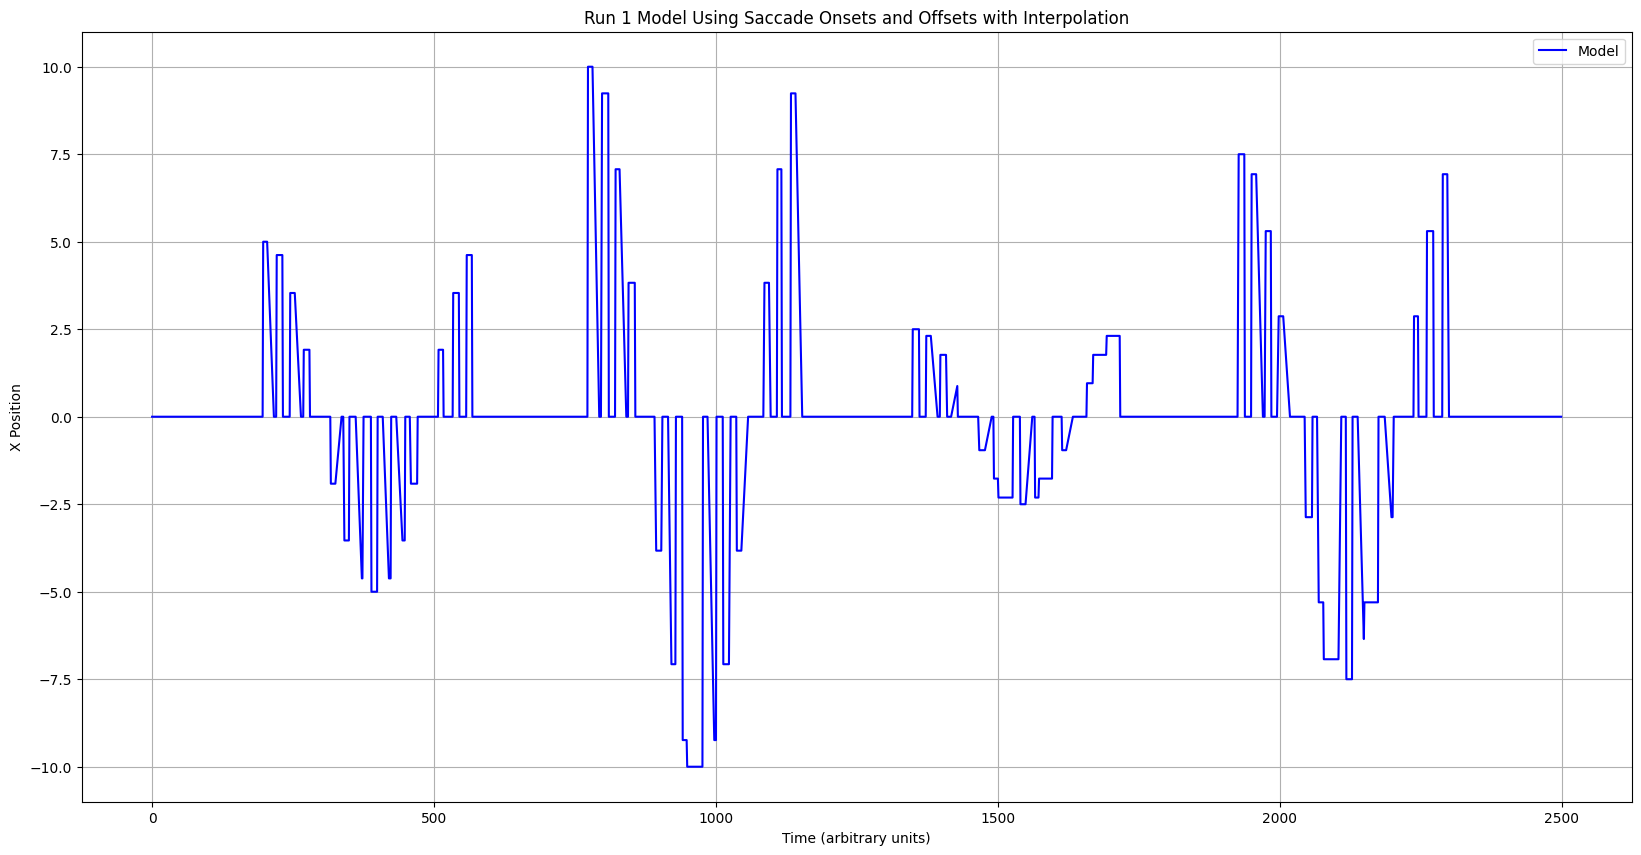

Model: [0. 0. 0. ... 0. 0. 0.]
case 1
case 1
case 2
case 3
orig onset 267
new set offset 276
case 1
case 1
case 2
case 2
case 4
case 1
case 1
case 1
case 2
case 1
case 2
case 1
case 1
case 1
case 1
case 1
case 1
case 1
case 1
case 4
case 4
case 2
case 1
case 3
orig onset 1036
new set offset 1045
case 1
case 1
case 1
case 1
case 1
case 3
orig onset 1373
new set offset 1381
case 3
orig onset 1394
new set offset 1405
case 3
orig onset 1420
new set offset 1429
case 4
case 4
case 4
case 4
case 1
case 1
case 1
case 1
case 4
case 1
case 2
case 1
case 1
case 1
case 1
case 1
case 1
case 1
case 1
case 3
orig onset 2093
new set offset 2102
case 3
orig onset 2114
new set offset 2126
case 3
orig onset 2140
new set offset 2150
case 4
case 2
case 1
case 4
case 2
case 1


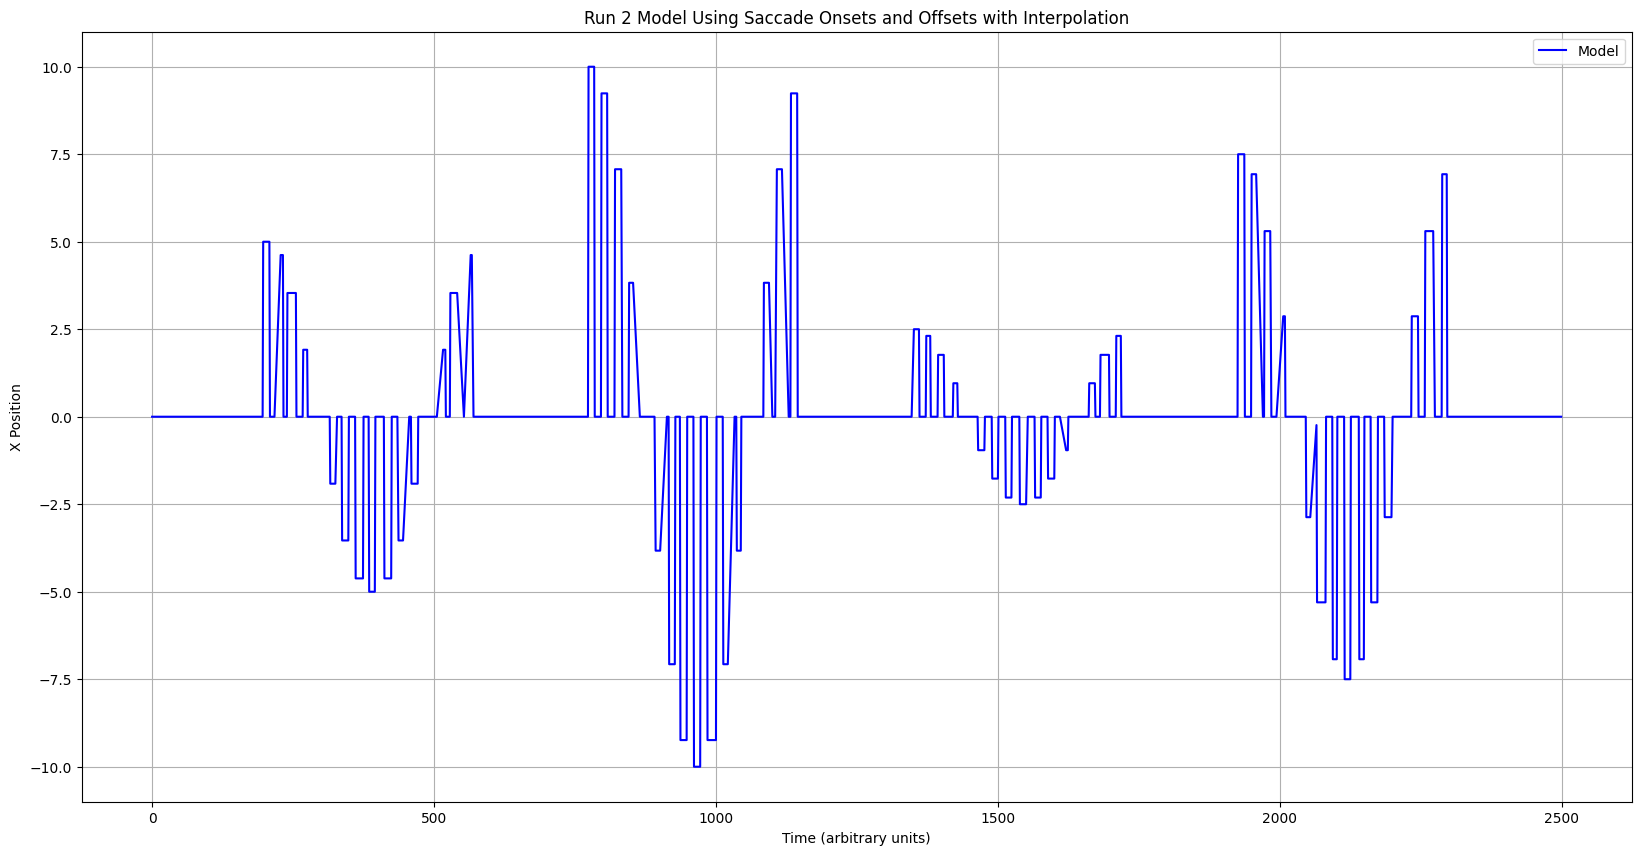

Model: [0. 0. 0. ... 0. 0. 0.]


In [50]:
# MODEL X
# Convert saccade onset times, relative to the start of the recording

out_filtered_dfs = [out_filtered_df_run_1,out_filtered_df_run_2]
in_filtered_dfs = [in_filtered_df_run_1,in_filtered_df_run_2]


trial_onsets_all = [onset_all_trials_flat_run_1,onset_all_trials_flat_run_2]
trial_offsets_all = [offset_all_trials_flat_run_1,offset_all_trials_flat_run_2]

for run, (out_filtered_df, in_filtered_df) in enumerate(zip(out_filtered_dfs, in_filtered_dfs)):
    eye_data = eye_data_all_runs[run]
    correct_sac_out_seconds_on = (out_filtered_df['sac_t_onset'] - eye_data[0, 0]) / 100
    correct_sac_out_seconds_off = (out_filtered_df['sac_t_offset'] - eye_data[0, 0]) / 100

    correct_sac_in_seconds_on = (in_filtered_df['sac_t_onset'] - eye_data[0, 0]) / 100
    correct_sac_in_seconds_off = (in_filtered_df['sac_t_offset'] - eye_data[0, 0]) / 100

    trial_onsets = trial_onsets_all[run]
    trial_offsets = trial_offsets_all[run]

    total_length = 2500  

    # Initialize the model with NaNs
    model_x = np.full(total_length, np.nan)

    current_index = 0

    for idx, (trial_in, trial_out) in enumerate(zip(trials_in, trials_out)):
        onset_out = int(list(correct_sac_out_seconds_on)[idx])
        offset_out = int(list(correct_sac_out_seconds_off)[idx])
        onset_in = int(list(correct_sac_in_seconds_on)[idx])
        offset_in = int(list(correct_sac_in_seconds_off)[idx])

        
        # Case 4: Both saccade outwards and inwards are missing
        if onset_out < 0 and onset_in < 0:
            print("case 4")
            onset_out = int(trial_onsets[trial_out - 2 ])
            offset_in = int(trial_offsets[trial_in])
            #print("new set onset", onset_out)
            #print("new set offset", offset_in)
            model_x[current_index:onset_out] = 0
            model_x[onset_out:offset_in] = sac_expected_x[trial_out]
            current_index = offset_in
            continue

        # Case 2: Saccade outwards is missing
        if onset_out < 0 or offset_out < 0:
            print("case 2")
            onset_out = int(list(trial_onsets)[trial_out - 2])
            #print("new set onset", onset_out)
            onset_in = int(list(correct_sac_in_seconds_on)[idx])
            model_x[current_index:onset_out] = 0
            model_x[onset_out:onset_in] = sac_expected_x[trial_out]
            #print(sac_expected_x[trial_out])
            offset_in = int(list(correct_sac_in_seconds_off)[idx])
            model_x[onset_in:offset_in] = np.interp(np.arange(onset_in, offset_in), [onset_in, offset_in], [sac_expected_x[trial_out], 0])
            current_index = offset_in
            continue

        # Case 3: Saccade inwards is missing
        if onset_in < 0 or offset_in < 0:
            print("case 3")
            onset_out = int(list(correct_sac_out_seconds_on)[idx])
            offset_out = int(list(correct_sac_out_seconds_off)[idx])
            offset_in = int(list(trial_offsets)[trial_in])
            print("orig onset", onset_out)
            print("new set offset", offset_in)
            model_x[current_index:onset_out] = 0
            model_x[onset_out:offset_out] = np.interp(np.arange(onset_out, offset_out), [onset_out, offset_out], [0, sac_expected_x[trial_out]])
            model_x[offset_out:offset_in] = sac_expected_x[trial_out]
            current_index = offset_in
            continue

        # Case 1: All saccades are present
        print('case 1')
        model_x[current_index:onset_out] = 0
        model_x[onset_out:offset_out] = np.interp(np.arange(onset_out, offset_out), [onset_out, offset_out], [0, sac_expected_x[trial_out]])
        model_x[offset_out:onset_in] = sac_expected_x[trial_out]
        model_x[onset_in:offset_in] = np.interp(np.arange(onset_in, offset_in), [onset_in, offset_in], [sac_expected_x[trial_out], 0])
        
        # Update current_index to the next saccade offset
        current_index = offset_in

    # If there are remaining data points after the last trial, set them to 0
    if current_index < total_length:
        model_x[current_index:] = 0

    plt.figure(figsize=(20, 10))
    plt.plot(model_x, label='Model', color='blue')
    plt.xlabel('Time (arbitrary units)')
    plt.ylabel('X Position')
    plt.title(f'Run {run + 1 } Model Using Saccade Onsets and Offsets with Interpolation')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Save 
    np.save(f"/Users/sinakling/disks/meso_shared/RetinoMaps/derivatives/pp_data/{subject}/eyetracking/timeseries/{subject}_run-0{run+1}_saccade_model_x", model_x)
    # Print the model for verification
    print("Model:", model_x)


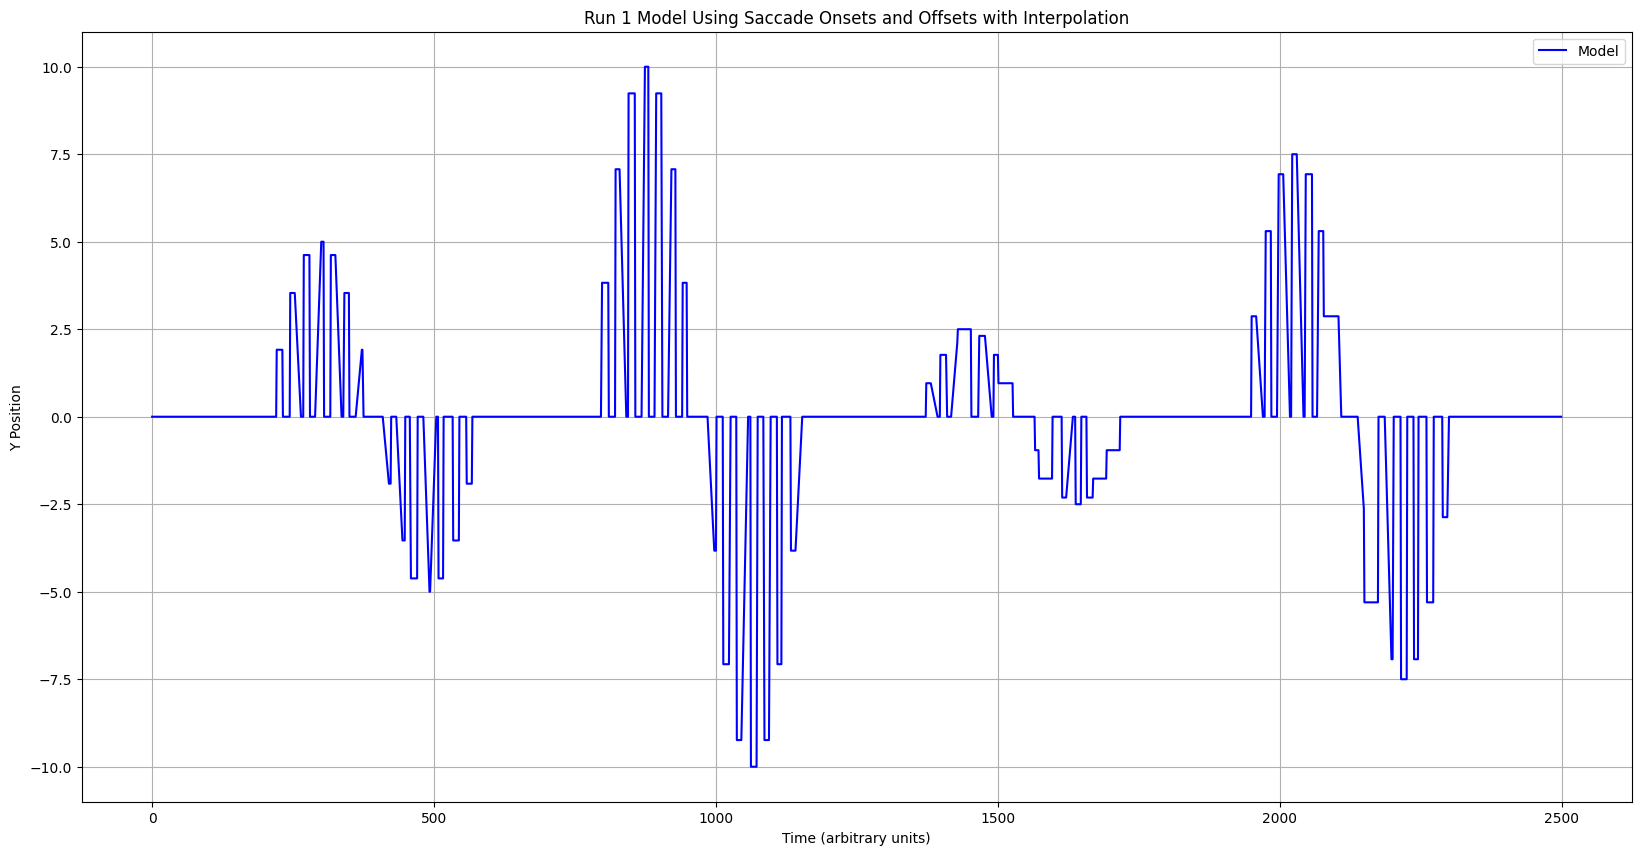

Model: [0. 0. 0. ... 0. 0. 0.]


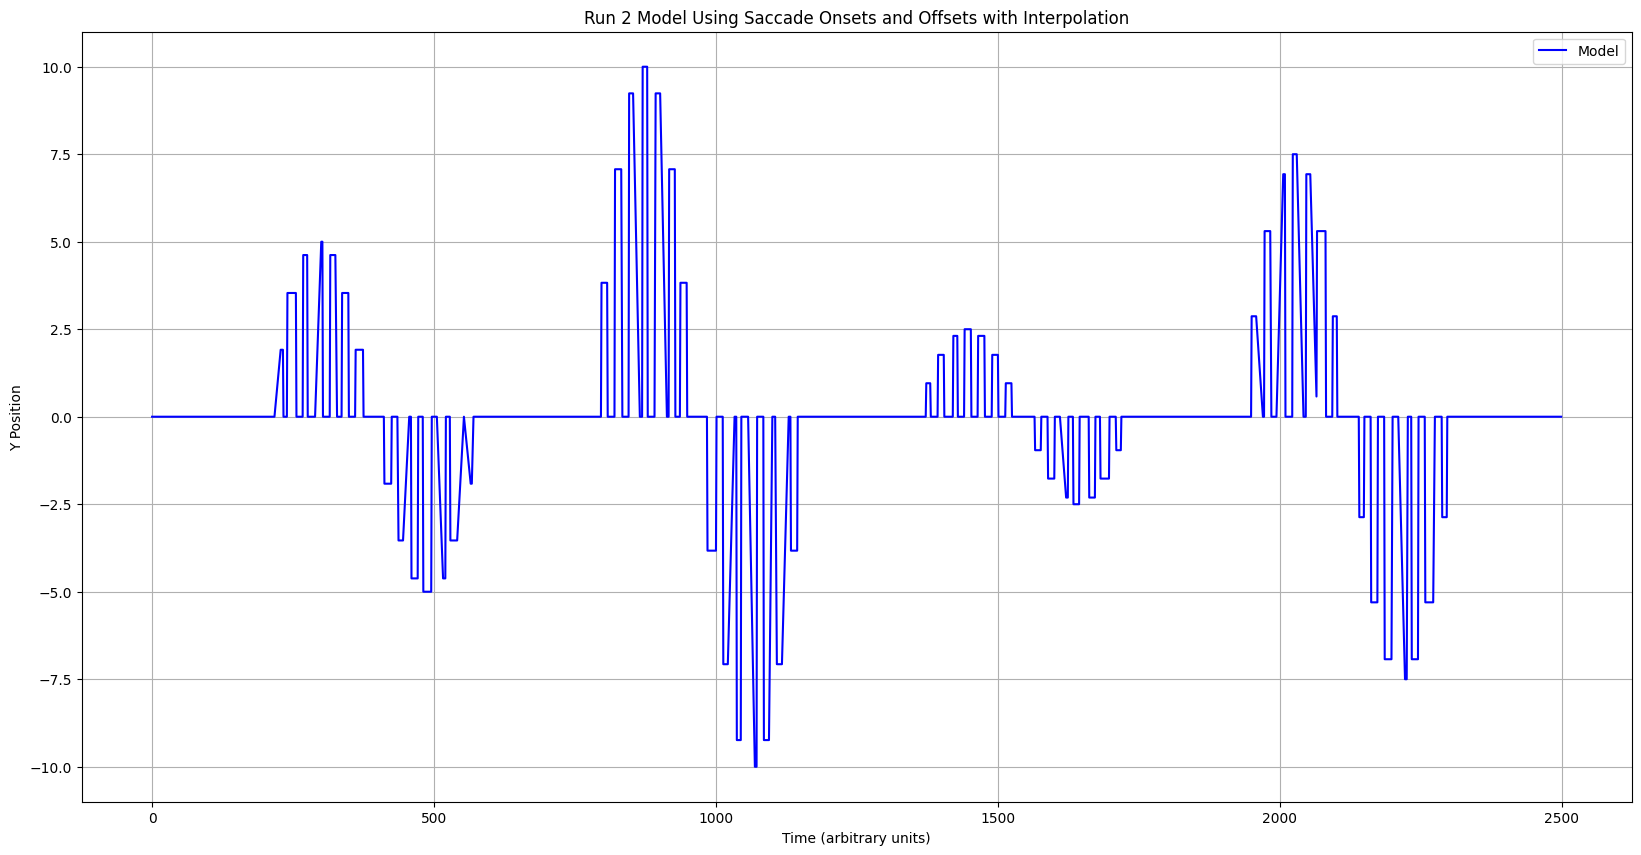

Model: [0. 0. 0. ... 0. 0. 0.]


In [51]:
# MODEL Y
# Convert saccade onset times, relative to the start of the recording

out_filtered_dfs = [out_filtered_df_run_1,out_filtered_df_run_2]
in_filtered_dfs = [in_filtered_df_run_1,in_filtered_df_run_2]


trial_onsets_all = [onset_all_trials_flat_run_1,onset_all_trials_flat_run_2]
trial_offsets_all = [offset_all_trials_flat_run_1,offset_all_trials_flat_run_2]

for run, (out_filtered_df, in_filtered_df) in enumerate(zip(out_filtered_dfs, in_filtered_dfs)):
    eye_data = eye_data_all_runs[run]
    correct_sac_out_seconds_on = (out_filtered_df['sac_t_onset'] - eye_data[0, 0]) / 100
    correct_sac_out_seconds_off = (out_filtered_df['sac_t_offset'] - eye_data[0, 0]) / 100

    correct_sac_in_seconds_on = (in_filtered_df['sac_t_onset'] - eye_data[0, 0]) / 100
    correct_sac_in_seconds_off = (in_filtered_df['sac_t_offset'] - eye_data[0, 0]) / 100

    trial_onsets = trial_onsets_all[run]
    trial_offsets = trial_offsets_all[run]


    total_length = 2500  

    # Initialize the model with NaNs
    model_y = np.full(total_length, np.nan)

    current_index = 0

    for idx, (trial_in, trial_out) in enumerate(zip(trials_in, trials_out)):
        onset_out = int(list(correct_sac_out_seconds_on)[idx])
        offset_out = int(list(correct_sac_out_seconds_off)[idx])
        onset_in = int(list(correct_sac_in_seconds_on)[idx])
        offset_in = int(list(correct_sac_in_seconds_off)[idx])
        
        # Case 4: Both saccade outwards and inwards are missing
        if onset_out < 0 and onset_in < 0:
            #print("case 4")
            onset_out = int(trial_onsets[trial_out - 2 ])
            offset_in = int(trial_offsets[trial_in])
            #print("new set onset", onset_out)
            #print("new set offset", offset_in)
            # 0 until trial outwards onset
            model_y[current_index:onset_out] = 0
            # Expected position until trial inwards offset
            model_y[onset_out:offset_in] = sac_expected_y[trial_out]
            current_index = offset_in
            continue

        # Case 2: Saccade outwards is missing
        if onset_out < 0 or offset_out < 0:
            #print("case 2")
            onset_out = int(list(trial_onsets)[trial_out - 2])
            #print("new set onset", onset_out)
            onset_in = int(list(correct_sac_in_seconds_on)[idx])
            offset_in = int(list(correct_sac_in_seconds_off)[idx])
            # 0 until trial outwards onset 
            model_y[current_index:onset_out] = 0
            # Expected position until saccade inwards onset
            model_y[onset_out:onset_in] = sac_expected_y[trial_out]
            # Interpolate between saccade inwards onset and offset
            model_y[onset_in:offset_in] = np.interp(np.arange(onset_in, offset_in), [onset_in, offset_in], [sac_expected_y[trial_out], 0])
            current_index = offset_in
            continue

        # Case 3: Saccade inwards is missing
        if onset_in < 0 or offset_in < 0:
            #print("case 3")
            onset_out = int(list(correct_sac_out_seconds_on)[idx])
            offset_out = int(list(correct_sac_out_seconds_off)[idx])
            offset_in = int(list(trial_offsets)[trial_in])
            #print("orig onset", onset_out)
            #print("new set offset", offset_in)
            # 0 until saccade outwards onset
            model_y[current_index:onset_out] = 0
            # Interpolate between saccade outwards onset and offset
            model_y[onset_out:offset_out] = np.interp(np.arange(onset_out, offset_out), [onset_out, offset_out], [0, sac_expected_y[trial_out]])
            # Expected position until trial inwards offset
            model_y[offset_out:offset_in] = sac_expected_y[trial_out]
            current_index = offset_in
            continue

        # Case 1: All saccades are present
        #print('case 1')
        # 0 until saccade outwards onset 
        model_y[current_index:onset_out] = 0
        # Interpolate between saccade outwards onset and offset
        model_y[onset_out:offset_out] = np.interp(np.arange(onset_out, offset_out), [onset_out, offset_out], [0, sac_expected_y[trial_out]])
        # Expected Position until saccade inwards onset
        model_y[offset_out:onset_in] = sac_expected_y[trial_out]
        # Interpolate between saccade inwards onset and offset 
        model_y[onset_in:offset_in] = np.interp(np.arange(onset_in, offset_in), [onset_in, offset_in], [sac_expected_y[trial_out], 0])
        
        # Update current_index to the next saccade offset
        current_index = offset_in

    # If there are remaining data points after the last trial, set them to 0
    if current_index < total_length:
        model_y[current_index:] = 0


    plt.figure(figsize=(20, 10))
    plt.plot(model_y, label='Model', color='blue')
    plt.xlabel('Time (arbitrary units)')
    plt.ylabel('Y Position')
    plt.title(f'Run {run +1} Model Using Saccade Onsets and Offsets with Interpolation')
    plt.grid(True)
    plt.legend()
    plt.show()


    # Save 
    np.save(f"/Users/sinakling/disks/meso_shared/RetinoMaps/derivatives/pp_data/{subject}/eyetracking/timeseries/{subject}_run-0{run+1}_saccade_model_y", model_y)
    # Print the model for verification
    print("Model:", model_y)


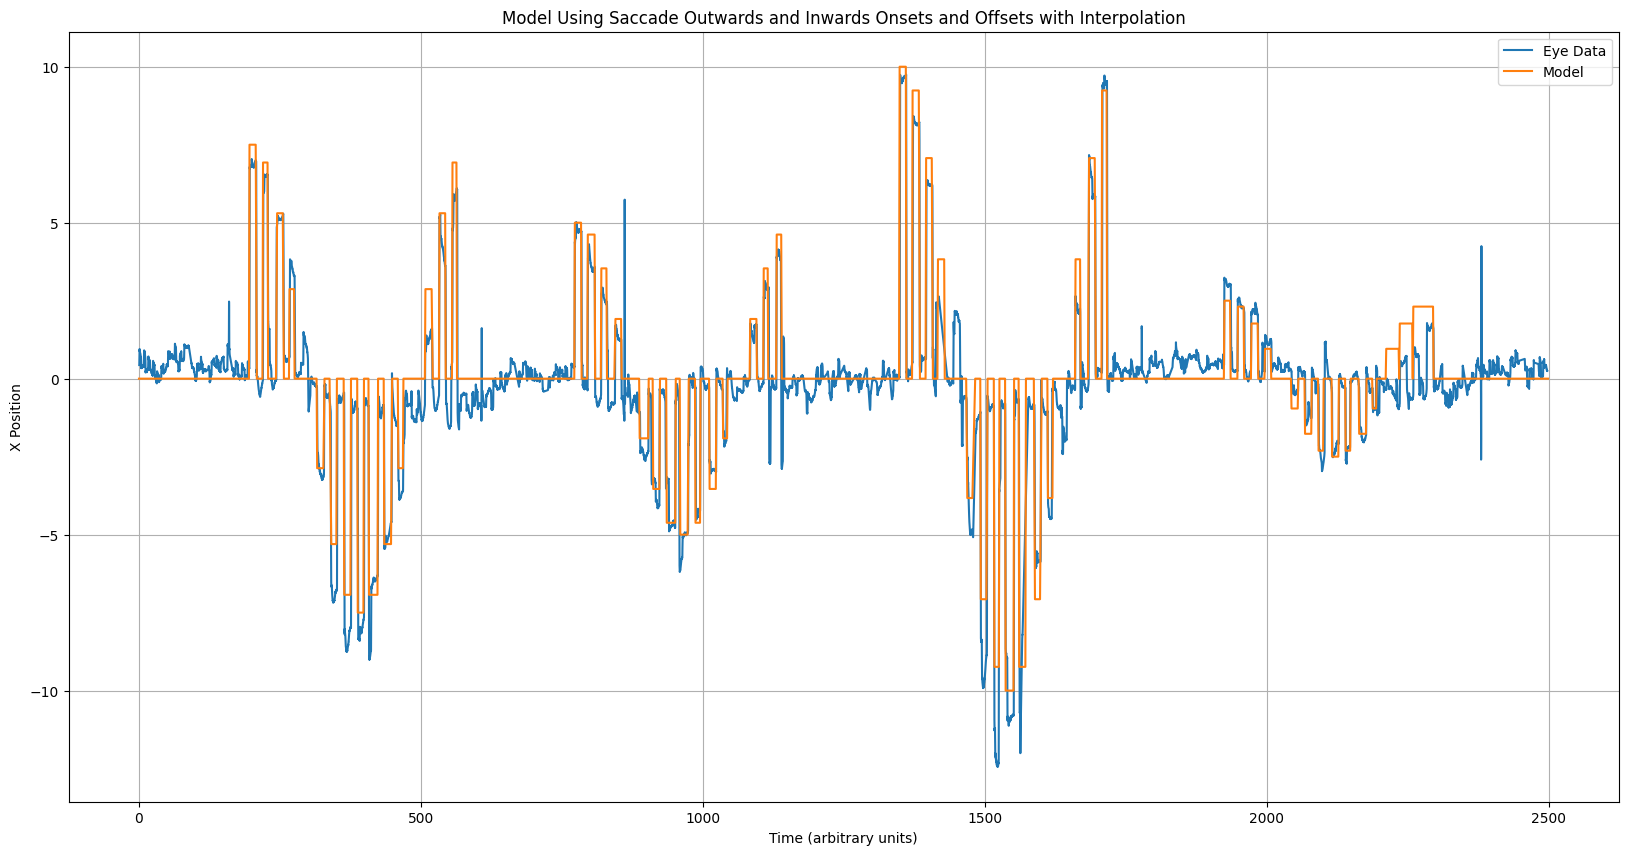

In [420]:
# Convert time to seconds, relative to the start of the recording
time_seconds = (eye_data_run_01_nan_blink_interpol[:, 0] - eye_data_run_01_nan_blink_interpol[0, 0]) / 100
eye_data = eye_data_run_01_nan_blink_interpol[:, 1]


# Convert saccade onset times to seconds, relative to the start of the recording
correct_sac_seconds_on = (correct_sac_out_run_1['sac_t_onset'] - eye_data_run_01_nan_blink_interpol[0, 0]) / 100
correct_sac_seconds_off = (correct_sac_out_run_1['sac_t_offset'] - eye_data_run_01_nan_blink_interpol[0, 0]) / 100

plt_1 = plt.figure(figsize=(20, 10)) 

# Plot eye data
plt.plot(time_seconds, eye_data, label='Eye Data')
plt.plot(model_x, label = 'Model')
plt.xlabel('Time (arbitrary units)')
plt.ylabel('X Position')
plt.title('Model Using Saccade Outwards and Inwards Onsets and Offsets with Interpolation')


plt.grid(True)
plt.legend()
plt.show()